This notebook is for development! Use it to try out new strategies :) 

<div class="alert alert-block alert-info">
<b>Imports:</b> Common imports for NumPy, MatplotLib, Pandas, and OS </div>

In [2]:
## Import for data generation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

<div class="alert alert-block alert-info">
<b>ML Imports:</b> Imports to execute RNN model for sequential data </div>

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from pyspark import SparkContext
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

<div class="alert alert-block alert-warning">
<b>nn_train_test() function:</b> 
    
This function creates the train and test sets a little differently. Instead of using pca to reduce dimensionality, it keeps all the data in anticipation of the Neural Net Framework to deal with filtering through it. The d variable allows you to discretize the grid down further as well.
    
    path --> path to the repository with all your .npy file
    n_future --> number of future days of fire you want to predict (will be 1 for us)
    n_comp --> Doesn't do anything right now
    n_past --> number of past days you want to consider (we can experiment with this)
    d --> The size of the discretized fires you want (i.e. d= 32, returns subset of sequences for 32x32 grids)
    
Outputs:
    
    input_dim is set to a 1-D array of 256 ^ 2 for now! 
    x_train --> x_train in format (batch_size, timesteps, input_dim)
    y_train --> training data in format (batch_size, input_dim)
    pca_array -->  Nothing
    
</div>

In [4]:
import nnUtils
from nnUtils import nn_train_test

<div class="alert alert-block alert-warning">
<b>RNN Inputs:</b> 
We are declaring below that the number of future days we want to predict is 1, and we can vary the number of past days
    we want to predict (I have the default as 3 for now)

</div>

In [5]:
n_future = 1
n_comp = 10
n_past = 3
discretization_amount = d = 64 # 256 means we keep the whole fire grid

<div class="alert alert-block alert-warning">
<b>Input Data for Training:</b> 
    Below, we get the input data from December 2018! 
</div>

In [6]:
%%capture 
# We are suppressing print statements and warning messages w/ above line
path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\jan\\storage"
months = ['feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug' ,'sep', 'oct', 'nov', 'dec']
x_train, y_train = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)
for month in months:
    path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\{mon}\\storage".format(mon = month)
    x, y  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)
    if len(x) == 0:
        continue
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))
    

<div class="alert alert-block alert-warning">
<b>Check:</b> 
    Check the shape of your x_train and y_train data
</div>

In [ ]:
x_train.shape, y_train.shape

<div class="alert alert-block alert-success">
    This follows the model in https://towardsdatascience.com/wildfire-spreading-modeling-in-alberta-canada-a-trial-using-a-neural-network-with-convlstm-cells-81c1a9f7d410. Their GitHub is at the bottom of the page 
    
<b>Train your RNN:</b> Train your RNN using the training data.
    
    You might notice a lot of arbitrary values here (these are things we will want to change and test)
    - Dropout: High dropout leads to more generalization. Low dropout takes advantage of more data but overfits more easily
    - # of hidden layers: Right now, there are 2 hidden layers (+ 1 at the end). We can change this
    - # units at hidden layers: Right now, units decrease by 1 at each hidden layer. This is arbitrary and can be changed
    - optimizer --> 'adam' works but I don't know what it does
    - epochs --> We can raise this above 1 but I don't notice that changing much when I have done so
    - batch_size --> Higher batch size leads to more generalization
</div>

Reshape your data as needed for the ConvLSTM

In [7]:
shuffler = np.random.permutation(len(x_train))
x_train = x_train[shuffler]
y_train = y_train[shuffler]

In [32]:
# No need to run this if you are loading a model
regressor = Sequential()

dropout = 0.0

regressor.add(tf.keras.layers.Conv2D(filters = 32,kernel_size = (3,3), padding = "valid", activation = "sigmoid", input_shape = (1)))

regressor.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

regressor.add(tf.keras.layers.Flatten())

regressor.add(tf.keras.layers.Dense(units = 4*64, activation = 'relu'))

regressor.add(tf.keras.layers.Dense(units = 8*64, activation = 'relu'))

regressor.add(tf.keras.layers.Dense(units = 16*64, activation = 'relu'))

regressor.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 2),
    tf.keras.callbacks.ModelCheckpoint(filepath='1D-output-256-2.h5'),   
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['acc'])

history = regressor.fit(x_train, y_train, epochs = 100, batch_size = 10, validation_split = 0.2, callbacks = my_callbacks)

import pickle
with open("C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\scripts\\history.pkl","w") as f:
    f.write(str(history.history))


TypeError: 'int' object is not iterable

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_train.shape

In [8]:
y_train = np.array([np.sum(y) for y in y_train])
x_train, y_train = x_train.reshape((int(x_train.shape[0]), d, d, 5)), y_train.reshape((int(y_train.shape[0]), 1))
x_train.shape, y_train.shape

((8560, 64, 64, 5), (8560, 1))

In [26]:
# No need to run this if you are loading a model
regressor = Sequential()

dropout = 0.0

#regressor.add(tf.keras.layers.Masking(mask_value=-9999,input_shape= x_train[0].shape)) 
regressor.add(tf.keras.layers.Conv2D(filters = 32,kernel_size = (3,3), padding = "valid", activation = "sigmoid", input_shape = x_train[0].shape))

regressor.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))

regressor.add(tf.keras.layers.Flatten())

regressor.add(tf.keras.layers.Dense(units = 32, activation = 'relu'))

regressor.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))

regressor.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

regressor.add(tf.keras.layers.Dense(units = 1, activation = 'relu'))

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 100),
    tf.keras.callbacks.ModelCheckpoint(filepath='1D-output-64-{epoch}.h5'),   
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['acc'])

history = regressor.fit(x_train, y_train, epochs = 100, batch_size = 10, validation_split = 0.2, callbacks = my_callbacks)

import pickle
with open("C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\scripts\\history.pkl","w") as f:
    f.write(str(history.history))


Epoch 1/100
685/685 [==============================] - 22s 28ms/step - loss: 160951.8906 - acc: 0.0213 - val_loss: 156857.7344 - val_acc: 0.0193
Epoch 2/100
685/685 [==============================] - 19s 27ms/step - loss: 147985.8906 - acc: 0.0194 - val_loss: 156431.2812 - val_acc: 0.0222
Epoch 3/100
685/685 [==============================] - 19s 27ms/step - loss: 144759.9219 - acc: 0.0450 - val_loss: 148843.6094 - val_acc: 0.4714
Epoch 4/100
685/685 [==============================] - 16s 24ms/step - loss: 143364.8906 - acc: 0.0258 - val_loss: 154478.8750 - val_acc: 0.0193
Epoch 5/100
685/685 [==============================] - 18s 27ms/step - loss: 142208.1719 - acc: 0.0209 - val_loss: 149454.7656 - val_acc: 0.0187
Epoch 6/100
685/685 [==============================] - 19s 27ms/step - loss: 139956.6094 - acc: 0.0305 - val_loss: 147782.2344 - val_acc: 0.0193
Epoch 7/100
685/685 [==============================] - 19s 28ms/step - loss: 140992.2188 - acc: 0.0384 - val_loss: 152285.3750 - v

KeyboardInterrupt: 

In [14]:
y_train = np.array([np.sum(y) for y in y_train])
x_train, y_train = x_train.reshape((int(x_train.shape[0]), 1, d, d, 5)), y_train.reshape((int(y_train.shape[0]), 1))
x_train.shape, y_train.shape

((8560, 1, 64, 64, 5), (8560, 1))

In [ ]:
regressor = Sequential()
# d = 64
act = "relu"
batch_normalization = True
layersd = 1 #1
layers2d = 1 #0
pooling2d = 1
layers4d = 2 #0
pooling4d = 1
pooling = True ## DO NOT CHANGE
dropout = 0.25
learning_rate = .01
epochs = 1000
dense = 1
train_range = range(0, len(x_train)) #range(0,50)#
t = len(train_range)

for i in range(layersd):
    regressor.add(tf.keras.layers.Conv3D(filters = d, kernel_size = (1,3,3), padding = "valid", activation = "sigmoid", input_shape = x_train[0].shape))

if pooling and layersd:
    regressor.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding="valid"))

if batch_normalization and layersd:
    regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))

if layersd:
    regressor.add(Dropout(dropout))

for i in range(layers2d):
    regressor.add(tf.keras.layers.Conv3D(filters = d*2, kernel_size = (1,3,3), padding = "valid", activation = act))

if batch_normalization and layers2d:
    regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))


for i in range(layers4d):
    regressor.add(tf.keras.layers.Conv3D(filters = d*4, kernel_size = (1,3,3), padding = "valid", activation = act))


for i in range(layers4d):
    regressor.add(tf.keras.layers.Conv3D(filters = d*4, kernel_size = (1,3,3), padding = "valid", activation = act))

if (pooling and layers4d) or pooling4d:
    regressor.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding="valid"))

if batch_normalization and layers4d:
    regressor.add(tf.keras.layers.BatchNormalization(center=True, scale=True))

regressor.add(tf.keras.layers.Flatten())

for i in range(dense):
    regressor.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 5),
    tf.keras.callbacks.ModelCheckpoint(filepath='1D-output.h5'),   
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

regressor.compile(optimizer = opt, loss = 'mse', metrics = ['acc'])

regressor.fit(x_train[train_range].reshape(t, 1, d, d, 5), y_train[train_range].reshape((t, 1)), epochs = epochs, batch_size = 1, callbacks = my_callbacks, validation_split = 0.2)
regressor.summary()

In [32]:
regressor = load_model('1D-output-256.h5')

In [ ]:
np.sum(b), np.sum(p), np.sum(y_train[38])


In [ ]:
x = x_train.reshape((x_train.shape[0],5, 64, 64))
predict_test = regressor.predict(x_train[21].reshape((1, d, d, 5)))
b = predict_test
plt.matshow(b.reshape((64,64)))
plt.show()
predict_test = regressor.predict(x_train[22].reshape((1, d, d, 5)))
p = predict_test
print("X")
plt.matshow(x[22][0])
plt.matshow(x[22][1])
plt.matshow(x[22][2])
plt.show()
plt.matshow(p.reshape((64,64)))
plt.show()
plt.matshow(y_train[22].reshape((64,64)))
predict_test = regressor.predict(x_train[159].reshape((1, 1, d, d, 4)))
p = predict_test
plt.matshow(p.reshape((64,64)))
plt.show()
plt.matshow(y_train[159].reshape((64,64)))
plt.show()

<div class="alert alert-block alert-success">
This follows the general layout of https://keras.io/examples/vision/conv_lstm/. I haven't had much success with it
    
<b>Train your RNN:</b> Train your RNN using the training data.
    
    You might notice a lot of arbitrary values here (these are things we will want to change and test)
    - Dropout: High dropout leads to more generalization. Low dropout takes advantage of more data but overfits more easily
    - # of hidden layers: Right now, there are 2 hidden layers (+ 1 at the end). We can change this
    - # units at hidden layers: Right now, units decrease by 1 at each hidden layer. This is arbitrary and can be changed
    - optimizer --> 'adam' works but I don't know what it does
    - epochs --> We can raise this above 1 but I don't notice that changing much when I have done so
    - batch_size --> Higher batch size leads to more generalization
</div>

<div class="alert alert-block alert-warning">
<b>Load pre-trained model:</b> 
    If you want to load a model instead, use this
</div>

In [27]:
from keras.models import load_model
model_name = '1D-output-64-11.h5' ## CHANGE THIS (e.g. 'my_model') ##
regressor = load_model(model_name)

<div class="alert alert-block alert-warning">
<b>Save pre-trained model:</b> 
    If you want to save a model instead, use this
</div>

In [ ]:
model_name = '1d-2018-output-10-44.h5'## CHANGE THIS (e.g. 'my_model') ##
regressor.save(model_name)

<div class="alert alert-block alert-warning">
<b>Input Data for Testing:</b> 
    Below, we get the input data from March 2018! 
</div>

In [28]:
%%capture
path = path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2017_Fires\\dec\\storage"
x_test, y_test  = nn_train_test(path, n_past = n_past, n_comp = n_comp, n_future = n_future, d = d)

<div class="alert alert-block alert-warning">
<b>Check:</b> I've noticed the first dimensions of these sometimes these don't match. They should.
</div>

In [ ]:
x_test, y_test = x_test.reshape((x_test.shape[0], 1, d, d, 5)), y_test.reshape((int(y_test.shape[0]), d, d))

In [29]:
y_test = np.array([np.sum(y) for y in y_test])
x_test, y_test = x_test.reshape((int(x_test.shape[0]),d, d, 5)), y_test.reshape((int(y_test.shape[0]), 1))
x_test.shape, y_test.shape

((7008, 64, 64, 5), (7008, 1))

<div class="alert alert-block alert-warning">
<b> Predict Step:</b> This makes your predictions using your model and reshapes them into a list of 2D arrays
</div>

In [13]:
predict_test = regressor.predict(x_test)
p = predict_test
shape = predict_test.shape

In [ ]:
np.sum(x_test[500:, :, :, 0:3])

In [73]:
np.sum(p), np.sum(y_test)

(725389.8, 773668.0)

In [ ]:
predict_train = regressor.predict(x_train)

In [21]:
plt.plot(y_train[0:100], 'blue')
plt.plot(predict_train[0:100], 'red')

NameError: name 'y_train' is not defined

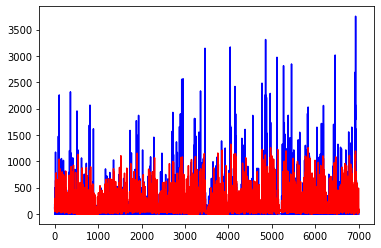

In [30]:
plt.plot(y_test, 'blue')
plt.plot(p, 'red')

In [ ]:
plt.plot(y_train, 'blue')
plt.plot(predict_train, 'red')